In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

EMBEDDING = models.Transformer('allenai/specter2_base')
POOLING = models.Pooling(EMBEDDING.get_word_embedding_dimension())
# POOLING = models.Pooling(EMBEDDING.get_word_embedding_dimension(), pooling_mode="cls") # CLS pooling

MODEL = SentenceTransformer(modules=[EMBEDDING, POOLING])

RANDOM_STATE = 1

def similarity_scoring(df, model, append=False):
    scores = df.apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["text_a"], r["text_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name="cosine-sim")
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2023-09-08 23:16:37.911372: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_csv("class-arxiv-dataset.csv", index_col=0)
df["label"] = df["label"].astype("float")
# TODO: the mathberta tokenizer also recognizes latex within [MATH]...[/MATH] -> convert latex markupp in titles accordingly
df.sample(5)

,label,categories_a,text_a,categories_b,text_b
4583,1.0,"('math.AP',)","Navier-Stokes equations: almost $L_{3,\infty}$...","('math.AP',)",Initial-boundary value problems in a rectangle...
6197,1.0,"('math.AP',)",Self-similar solutions for a superdiffusive he...,"('math.AP',)",Characterization of gradient Young measures ge...
31529,0.0,"('math.GT',)",Complexities of 3-manifolds from triangulation...,"('stat.ME',)",On Scalable Particle Markov Chain Monte Carlo....
38142,0.0,"('math.NT',)","Permanents, Determinants, Weighted Isobaric Po...","('math.AG',)",Monodromy of A-hypergeometric functions. Using...
41366,1.0,"('math.OC',)",Polynomial Matrix Inequalities within Tame Geo...,"('math.OC',)",On computing the distance to stability for mat...


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 43572 eval: 5447 test: 5447


In [4]:
# prepare evaluation data
eval_examples = X_eval.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples)

In [5]:
# prepare re-training: training data, loss
retrain_examples = X_train.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
retrain_dataloader = DataLoader(retrain_examples, shuffle=True, batch_size=8)
#retrain_loss = losses.SoftmaxLoss(model=MODEL, num_labels=2,
#        sentence_embedding_dimension=MODEL.get_sentence_embedding_dimension())
#retrain_loss = losses.ContrastiveLoss(model=MODEL)
retrain_loss = losses.CosineSimilarityLoss(model=MODEL)

In [6]:
%%time
# finetune model
MODEL.fit(train_objectives=[(retrain_dataloader, retrain_loss)], evaluator=evaluator, epochs=10,
        output_path="specter2+mp+retrain_class_arxiv") 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5447 [00:00<?, ?it/s]

CPU times: user 7h 28min 24s, sys: 59min 6s, total: 8h 27min 31s
Wall time: 6h 51min 57s


In [7]:
%%time
# evaluate Spearman-Pearson-rank-coefficient on test data
spear_ranc = MODEL.evaluate(evaluator)
spear_ranc

CPU times: user 2min 32s, sys: 6.8 s, total: 2min 39s
Wall time: 1min 18s


0.7877710474574123

In [8]:
%%time
# evaluate model with test data
X_test_score = similarity_scoring(X_test, MODEL, append=True)

CPU times: user 2min 4s, sys: 2.56 s, total: 2min 7s
Wall time: 1min 43s


In [9]:
pd.set_option('display.max_colwidth', 160)

In [10]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,label,categories_a,text_a,categories_b,text_b,cosine-sim
14175,1.0,"('math.CO',)","On Weak Chromatic Polynomials of Mixed Graphs. A \emph{mixed graph} is a graph with directed edges, called arcs, and undirected edges. A $k$-coloring of the...","('math.CO',)","Projective Equivalences of k-neighbourly Polytopes. We prove the following theorem, which is related to McMullen's problem on projective transformations of ...",0.998974
29240,1.0,"('math.GR',)","Galois Theory - a first course. These notes are a self-contained introduction to Galois theory, designed for the student who has done a first course in abst...","('math.GR',)",On p-stability in groups and fusion systems. The aim of this paper is to generalise the notion of p-stability to fusion systems. We study the question how Q...,0.879727
31864,1.0,"('math.KT',)",Controlled $K$-theory and $K$-Homology. An operator $T$ in a $C^*$-algebra is called an $\epsilon$-projection if it satisfies $T=T^*$ and $\|T^2-T\|<\epsilo...,"('math.KT',)","Cyclic homology of braided Hopf crossed products. Let k be a field, A a unitary associative k-algebra and V a k-vector space endowed with a distinguished el...",0.980329
48373,1.0,"('math.RA',)",Simple subalgebras of simple special Jordan algebras. In this paper we determine all types and the canonical forms of simple subalgebras for each type of si...,"('math.RA',)",Normalization of Quaternionic Polynomials. Quaternionic polynomials are generated by quaternionic variables and the quaternionic product. This paper propose...,0.390742
11994,1.0,"('math.CA',)","On some Hadamard-Type Inequalities for Co-ordinated Convex Functions. In this paper, we prove some new inequalities of Hadamard-type for convex functions on...","('math.CA',)",Non-differentiable solutions for local fractional nonlinear Riccati differential equations. We investigate local fractional nonlinear Riccati differential e...,0.498372
48427,1.0,"('math.RA',)",Basic superranks for varieties of algebras. We introduce the notion of basic superrank for varieties of algebras which generalizes that of basic rank. First...,"('math.RA',)","A note on solvable maximal subgroups in subnormal subgroups of ${\mathrm GL}_n(D)$. Let $D$ be a non-commutative division ring, $G$ a subnormal subgroup of ...",0.990994
22315,0.0,"('math.DG',)","Tensor tomography on Cartan-Hadamard manifolds. We study the geodesic X-ray transform on Cartan-Hadamard manifolds, and prove solenoidal injectivity of this...","('math.OC',)","A new conical internal evolutive LP algorithm. In a previous paper, published in 1992, a primal conical LP algorithm with exact finite coonvergence was pres...",-0.014653
51367,1.0,"('stat.AP',)","Data-driven dynamic treatment planning for chronic diseases. In order to deliver effective care, health management must consider the distinctive trajectorie...","('stat.AP',)",Statistical analysis of stellar evolution. Color-Magnitude Diagrams (CMDs) are plots that compare the magnitudes (luminosities) of stars in different wavele...,0.977827
39212,0.0,"('math.NT',)",The distribution of spacings between the fractional parts of $\boldsymbol{n^d\alpha}$. We study the distribution of spacings between the fractional parts of...,"('math.FA',)",Canonical graph contractions of linear relations on Hilbert spaces. Given a closed linear relation $T$ between two Hilbert spaces $\mathcal H$ and $\mathcal...,0.835174
51254,1.0,"('stat.AP',)",Bayesian model averaging for mortality forecasting using leave-future-out validation. Predicting the evolution of mortality rates plays a central role for l...,"('stat.AP',)",Selection of multiple donor gauges via Graphical Lasso for estimation of daily streamflow time series. A fundamental challenge in estimations of daily strea...,0.989956


In [11]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cosine-sim
count,2766.0,2766.000000
mean,1.0,0.766400
std,0.0,0.351667
min,1.0,-0.035556
25%,1.0,0.612003
50%,1.0,0.981389
75%,1.0,0.996774
max,1.0,0.999794


In [12]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cosine-sim
count,2681.0,2681.000000
mean,0.0,0.051254
std,0.0,0.180724
min,0.0,-0.078793
25%,0.0,-0.004560
50%,0.0,0.000396
75%,0.0,0.012264
max,0.0,0.999281


<AxesSubplot:>

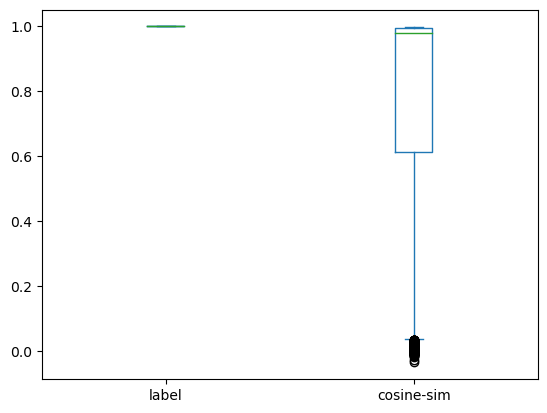

In [13]:
X_test_score[X_test_score["label"] == 1].plot.box()

<AxesSubplot:>

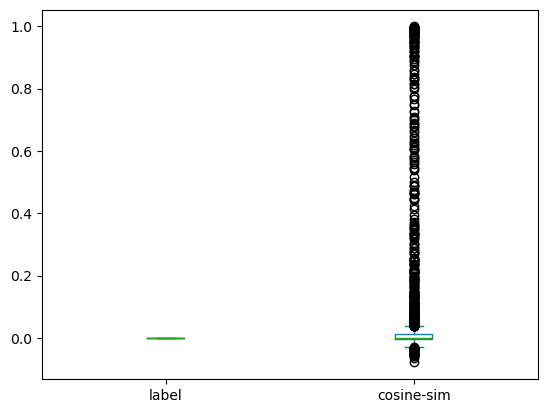

In [14]:
X_test_score[X_test_score["label"] == 0].plot.box()